# Age Stratified Model

This notebook demonstrates how to construct a multi-season age stratified model.

In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# stdlib dependencies
import pathlib

# External dependency imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

# `vaxflux` imports
from vaxflux.multilevel_model import (
    UptakeModelConfig,
    create_multilevel_model,
    generate_model_outputs,
)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


TODO: Discuss the dataset some

In [2]:
with (
    pathlib.Path("~/Documents/vacc_alldoses_age_Flu_2024_R1_allflu_allseasons.csv")
    .expanduser()
    .open() as f
):
    vacc_df = pd.read_csv(f)

columns = vacc_df.columns.tolist()
vacc_df["name"] = vacc_df["NAME"].astype("string")
vacc_df = vacc_df[["name"] + columns[1:]]
vacc_df["end_date"] = pd.to_datetime(vacc_df["end_date"])
vacc_df["age_group"] = vacc_df["age_group"].astype("string")
vacc_df["USPS"] = vacc_df["USPS"].astype("string")
vacc_df["start_date"] = pd.to_datetime(vacc_df["start_date"])
vacc_df["dose"] = vacc_df["dose"].astype("string")
vacc_df["scenario"] = vacc_df["scenario"].astype("string")
vacc_df["date"] = pd.to_datetime(vacc_df["date"])
vacc_df["date_admin"] = pd.to_datetime(vacc_df["date_admin"])
vacc_df["season"] = vacc_df["season"].astype("string")
vacc_df["seasonid"] = vacc_df["seasonid"].astype("string")

subset_vacc_df = vacc_df[["season", "USPS", "age_group", "date", "prop_vacc_age"]]
subset_vacc_df.columns = ["season", "region", "strata", "time", "rate"]
subset_vacc_df = subset_vacc_df[subset_vacc_df["region"] == "NC"]

subset_vacc_df

,season,region,strata,time,rate
5535,2010-11,NC,0_4,2010-08-28,0.0000
5536,2010-11,NC,0_4,2010-09-04,0.0608
5537,2010-11,NC,0_4,2010-09-11,0.0650
5538,2010-11,NC,0_4,2010-09-18,0.0776
5539,2010-11,NC,0_4,2010-09-25,0.0963
...,...,...,...,...,...
141416,2023-24,NC,65_100,2024-05-05,0.7030
141417,2023-24,NC,65_100,2024-05-12,0.7030
141418,2023-24,NC,65_100,2024-05-19,0.7030
141419,2023-24,NC,65_100,2024-05-26,0.7030


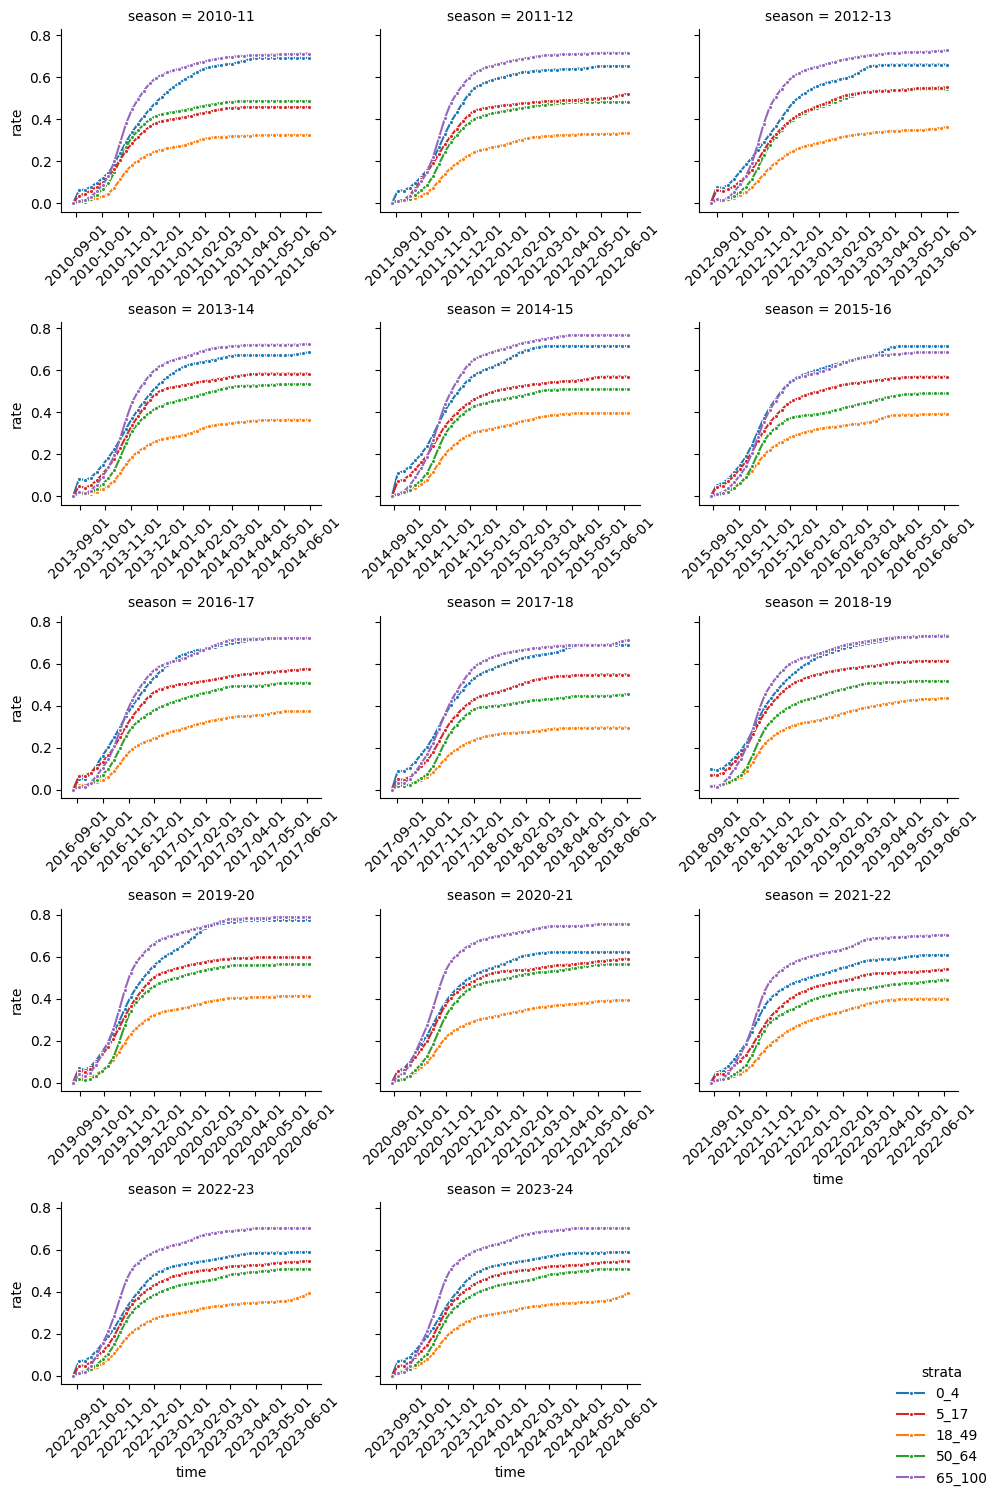

In [3]:
g = sns.FacetGrid(
    data=subset_vacc_df, col="season", hue="strata", col_wrap=3, sharex=False
)
g.map(sns.lineplot, "time", "rate", marker=".")
g.set_xticklabels(rotation=45)
g.add_legend(label_order=["0_4", "5_17", "18_49", "50_64", "65_100"], loc="lower right")
plt.tight_layout()
plt.show()

## The Model

The model being used here will be largely based on the one from the `multiseason_model.ipynb` notebook. Let $i=1,\dots,N_{\mathrm{seasons}}$ and $j=1,\dots,N_{\mathrm{strata}}$, then

$$ k_i \sim \mathcal{N}\left( \mu_k, \sigma_k^2 \right) $$

$$ r \sim \mathcal{N}\left( \mu_r, \sigma_r^2 \right) $$

$$ s \sim \mathcal{N}\left( \mu_s, \sigma_s^2 \right) $$

$$ \delta k_j \sim \mathcal{N}\left( \mu_{\delta k_{\mathrm{strata}}}, \sigma_{\delta k_{\mathrm{strata}}}^2 \right) $$

$$ \delta r_j \sim \mathcal{N}\left( \mu_{\delta r_{\mathrm{strata}}}, \sigma_{\delta r_{\mathrm{strata}}}^2 \right) $$

$$ \delta s_j \sim \mathcal{N}\left( \mu_{\delta s_{\mathrm{strata}}}, \sigma_{\delta s_{\mathrm{strata}}}^2 \right) $$

$$ \epsilon \sim \mathrm{HalfNormal}\left( \epsilon_{\mathrm{prior}} \right) $$

$$ y_{ij}(t) \sim \mathcal{N}\left( f\left( t \vert K_{ij}, r + \delta r_j, s + \delta s_j \right), \epsilon^2 \right) $$

where $K_{ij} = \left( 1 + e^{-\left(k_i + \delta k_j\right)} \right)^{-1}$ and $f(t\vert k,r,s)$ is a logistic function given by

$$ f\left( t \vert k, r ,s \right) = \frac{k}{1 + e^{-r(t - s)}}. $$

## Constructing The Model With `vaxflux`

Now to build this model using `vaxflux` the first step is to construct an `UptakeModelConfig` object that describes this model. The priors for $k_i$, $r$, and $s$ are mildly informative whereas the priors for $\delta k_j$, $\delta r_j$, and $\delta s_j$ are strongly informative. The reason being it is preferable for comparison purposes that the model attempt to explain more of the variance using the non-strata parameters.

In [4]:
# Construct a DataFrame of season starts
season_starts = pd.DataFrame(
    data=[
        {"season": f"20{i}-{i + 1}", "start_time": f"20{i}-08-15"}
        for i in range(10, 24)
    ]
)
season_starts["season"] = season_starts["season"].astype("string")
season_starts["start_time"] = pd.to_datetime(season_starts["start_time"])

# Merge and make calculation
data_df = subset_vacc_df.merge(season_starts, on="season")
data_df["time"] = (data_df["time"] - data_df["start_time"]).dt.days
data_df = data_df.drop(columns=["start_time"])

In [5]:
uptake_config = UptakeModelConfig(
    name="Multi-Season Age Stratified Uptake Model For NC",
    data=data_df,
    eps_prior=0.1,
    k_prior=(0.0, 0.5),
    r_prior=(0.5, 0.25),
    s_prior=(30.0, 6.0),
    dk_strata_prior=(0.0, 0.5),
    dr_strata_prior=(0.0, 0.05),
    ds_strata_prior=(0.0, 1.0),
)
uptake_config

<vaxflux.multilevel_model.UptakeModelConfig named 'Multi-Season Age Stratified Uptake Model For NC'>

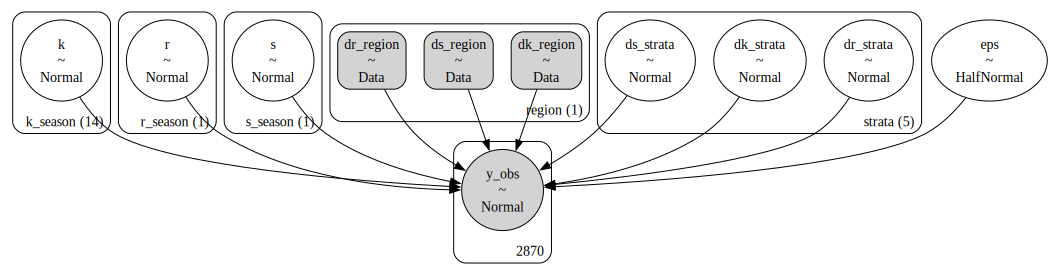

In [6]:
model = create_multilevel_model(uptake_config)
pm.model_to_graphviz(model)

TODO: Discuss the model

## Sampling The Model 

The next thing to do is to sample from the model and then evaluate how well it performs.

In [7]:
chains = 4
samples = 1000 * chains
with model:
    trace = pm.sample(
        draws=samples, tune=samples, chains=chains, cores=chains, random_seed=123
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, r, s, dk_strata, dr_strata, ds_strata, eps]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 369 seconds.
There were 1169 divergences after tuning. Increase `target_accept` or reparameterize.


In [8]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
dk_strata[0_4],0.614,0.116,0.403,0.834,0.003,0.002,1239.0,2085.0,1.0
dk_strata[18_49],-0.663,0.116,-0.877,-0.448,0.003,0.002,1260.0,1959.0,1.0
dk_strata[50_64],-0.094,0.116,-0.313,0.117,0.003,0.002,1250.0,2068.0,1.0
dk_strata[5_17],0.106,0.116,-0.105,0.324,0.003,0.002,1254.0,2134.0,1.0
dk_strata[65_100],0.811,0.116,0.594,1.023,0.003,0.002,1245.0,2086.0,1.0
dr_strata[0_4],-0.009,0.022,-0.050,0.034,0.000,0.000,2332.0,3349.0,1.0
dr_strata[18_49],-0.005,0.022,-0.045,0.039,0.000,0.000,2320.0,3333.0,1.0
dr_strata[50_64],0.005,0.022,-0.037,0.046,0.000,0.000,2319.0,3272.0,1.0
dr_strata[5_17],-0.004,0.022,-0.044,0.040,0.000,0.000,2308.0,3325.0,1.0
dr_strata[65_100],0.008,0.022,-0.033,0.051,0.000,0.000,2335.0,3283.0,1.0


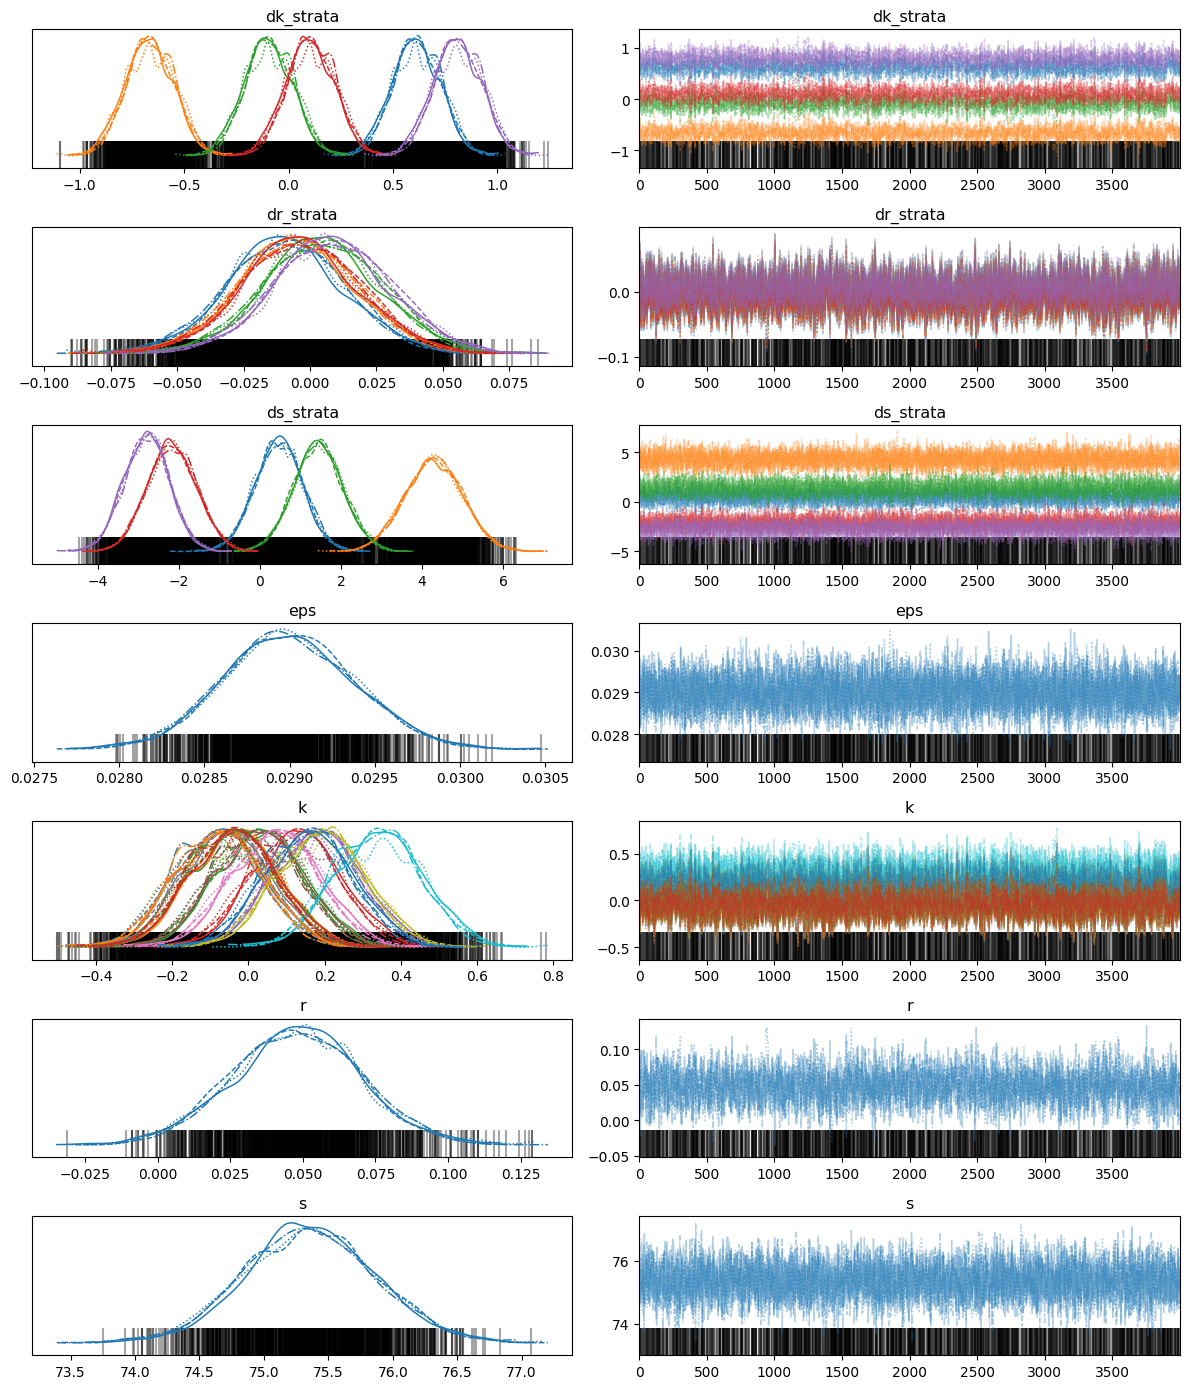

In [9]:
axes = az.plot_trace(trace, kind="trace")
plt.tight_layout()

TODO: Discuss convergence

In [10]:
t = np.linspace(0.0, 300.0, 600)
output = generate_model_outputs(trace, t)
output.shape

(600, 16000, 14, 1, 5)

In [11]:
quantile_output = output.quantile((0.005, 0.5, 0.995), dim="sample")
quantile_output.shape

(3, 600, 14, 1, 5)